In [79]:
# 모델 구조(summary)를 확인하기 위한 라이브러리 설치
!pip install torchinfo
!pip install tensorflow
!pip install tensorflow-datasets
!pip install opencv-python

In [80]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as F
import torchvision.transforms as transforms
import torchvision.models as models
from torch.optim.lr_scheduler import LambdaLR
from torch.utils.data import DataLoader, Dataset

import os, copy
import cv2
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

DATA_PATH = 'home/jovyan/work/object_detection/images'

print('슝=3')

슝=3


In [16]:
(ds_train, ds_test), ds_info = tfds.load(
    'kitti',
    data_dir=DATA_PATH,
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)
print('슝=3')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

W0000 00:00:1764042242.284965     160 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Shuffling home/jovyan/work/object_detection/images/kitti/incomplete.FJUU5P_3.3.0/kitti-train.tfrecord*...:   0…

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling home/jovyan/work/object_detection/images/kitti/incomplete.FJUU5P_3.3.0/kitti-validation.tfrecord*...…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling home/jovyan/work/object_detection/images/kitti/incomplete.FJUU5P_3.3.0/kitti-test.tfrecord*...:   0%…

Dataset kitti downloaded and prepared to home/jovyan/work/object_detection/images/kitti/3.3.0. Subsequent calls will reuse this data.
슝=3


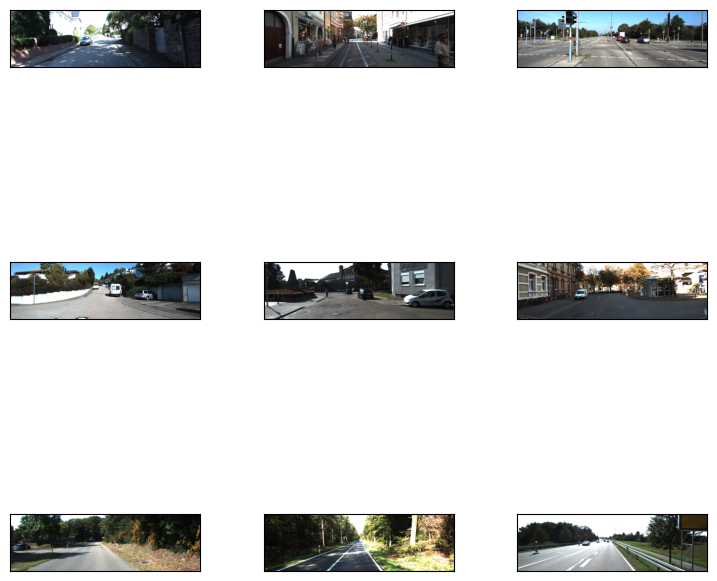

In [81]:
_ = tfds.show_examples(ds_train, ds_info)

In [82]:
ds_info

tfds.core.DatasetInfo(
    name='kitti',
    full_name='kitti/3.3.0',
    description="""
    Kitti contains a suite of vision tasks built using an autonomous driving
    platform. The full benchmark contains many tasks such as stereo, optical flow,
    visual odometry, etc. This dataset contains the object detection dataset,
    including the monocular images and bounding boxes. The dataset contains 7481
    training images annotated with 3D bounding boxes. A full description of the
    annotations can be found in the readme of the object development kit readme on
    the Kitti homepage.
    """,
    homepage='http://www.cvlibs.net/datasets/kitti/',
    data_dir='home/jovyan/work/object_detection/images/kitti/3.3.0',
    file_format=tfrecord,
    download_size=11.71 GiB,
    dataset_size=5.27 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'image/file_name': Text(shape=(), dtype=string),
        'objects': Sequence({
            'al

------Example------
['image', 'image/file_name', 'objects']
------objects------
{'alpha': <tf.Tensor: shape=(11,), dtype=float32, numpy=
array([ 2.43,  1.94, -1.82,  1.77,  1.28, -0.49, -1.45, -1.23, -3.12,
       -1.06,  2.23], dtype=float32)>, 'bbox': <tf.Tensor: shape=(11, 4), dtype=float32, numpy=
array([[0.00266667, 0.        , 0.40141332, 0.20672303],
       [0.00266667, 0.08797906, 0.47797334, 0.37694043],
       [0.00266667, 0.6811272 , 0.5428    , 0.97288245],
       [0.33632   , 0.35143316, 0.5493867 , 0.42633656],
       [0.37885332, 0.37507245, 0.5233333 , 0.44940418],
       [0.51746666, 0.5759823 , 0.5774133 , 0.6307327 ],
       [0.20216   , 0.67591786, 0.5268267 , 0.79124796],
       [0.32770666, 0.71278584, 0.5644533 , 0.82365537],
       [0.43117332, 0.61235106, 0.57114667, 0.7259823 ],
       [0.3924    , 0.92241544, 0.5624533 , 0.99919486],
       [0.45909333, 0.8261192 , 0.56192   , 0.91829306]], dtype=float32)>, 'dimensions': <tf.Tensor: shape=(11, 3), dtype=float

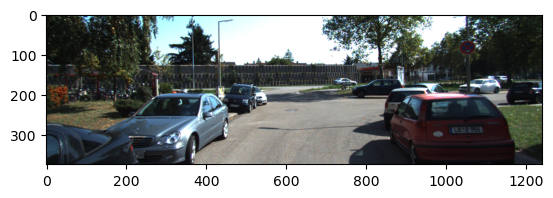

In [83]:
sample = ds_train.take(1)

for example in sample:
    print('------Example------')
    print(list(example.keys()))
    image = example["image"]
    filename = example["image/file_name"].numpy().decode('utf-8')
    objects = example["objects"]

print('------objects------')
print(objects)

img = Image.fromarray(image.numpy())
plt.imshow(img)
plt.show()

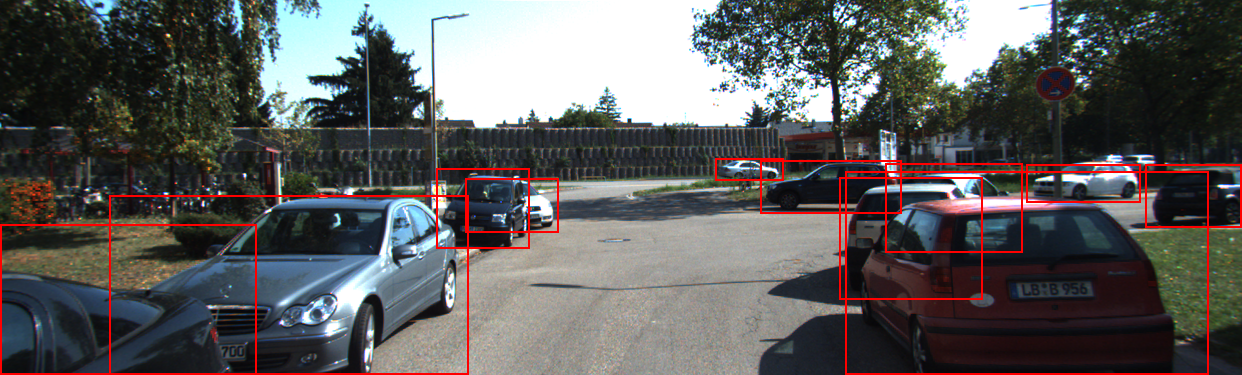

In [84]:
# 이미지 위에 바운딩 박스를 그려 화면에 표시해 주세요.
def visualize_bbox(input_image, object_bbox):
    input_image = copy.deepcopy(input_image)
    draw = ImageDraw.Draw(input_image)

    # 바운딩 박스 좌표(x_min, x_max, y_min, y_max) 구하기
    width, height = img.size
    x_min = object_bbox[:,1] * width
    x_max = object_bbox[:,3] * width
    y_max = height - object_bbox[:,0] * height
    y_min = height - object_bbox[:,2] * height

    # 바운딩 박스 그리기
    rects = np.stack([x_min, y_min, x_max, y_max], axis=1)
    for _rect in rects:
        draw.rectangle(_rect, outline=(255,0,0), width=2)

    return input_image

visualize_bbox(img, objects['bbox'].numpy())

In [85]:
def swap_xy(boxes):
    return torch.stack([boxes[:, 1], boxes[:, 0], boxes[:, 3], boxes[:, 2]], dim=-1)

print("슝=3")

슝=3


In [86]:
def random_flip_horizontal(image, boxes):
    if torch.rand(1).item() > 0.5:
        image = F.hflip(image)
        boxes = torch.stack(
            [1 - boxes[:, 2], boxes[:, 1], 1 - boxes[:, 0], boxes[:, 3]], dim=-1
        )

    return image, boxes

print("슝=3")

슝=3


In [87]:
def resize_and_pad_image(image, training=True):
    min_side = 800.0
    max_side = 1333.0
    min_side_range = [640, 1024]
    stride = 128.0

    image_shape = torch.tensor(image.shape[-2:], dtype=torch.float32)
    if training:
        min_side = torch.empty(1).uniform_(min_side_range[0], min_side_range[1]).item()
    ratio = min_side / torch.min(image_shape)
    if ratio * torch.max(image_shape) > max_side:
        ratio = max_side / torch.max(image_shape)
    image_shape = ratio * image_shape
    new_size = tuple(image_shape.round().int().tolist())
    image = F.resize(image, new_size)
    padded_image_shape = torch.ceil(image_shape / stride) * stride
    padded_image_shape = padded_image_shape.int().tolist()
    pad_h = padded_image_shape[0] - new_size[0]
    pad_w = padded_image_shape[1] - new_size[1]
    image = F.pad(image, (0, pad_w, 0, pad_h))
    return image, torch.tensor(new_size), ratio

print("슝=3")

슝=3


In [88]:
def convert_to_xywh(boxes):
    return torch.cat(
        [(boxes[..., :2] + boxes[..., 2:]) / 2.0,
         boxes[..., 2:] - boxes[..., :2]],
        dim=-1
    )

print("슝=3")

슝=3


In [89]:
def preprocess_data(sample):
    image = sample["image"]
    bbox = swap_xy(sample["objects"]["bbox"])
    class_id = sample["objects"]["type"].to(torch.int32)

    image, bbox = random_flip_horizontal(image, bbox)
    image, image_shape, _ = resize_and_pad_image(image)

    bbox = torch.stack(
        [
            bbox[:, 0] * image_shape[1],
            bbox[:, 1] * image_shape[0],
            bbox[:, 2] * image_shape[1],
            bbox[:, 3] * image_shape[0],
        ],
        dim=-1
    )
    bbox = convert_to_xywh(bbox)

    return image, bbox, class_id

print("슝=3")

슝=3


In [90]:
class AnchorBox:
    def __init__(self):
        self.aspect_ratios = [0.5, 1.0, 2.0]
        self.scales = [2 ** x for x in [0, 1 / 3, 2 / 3]]

        self._num_anchors = len(self.aspect_ratios) * len(self.scales)
        self._strides = [2 ** i for i in range(3, 8)]
        self._areas = [x ** 2 for x in [32.0, 64.0, 128.0, 256.0, 512.0]]
        self._anchor_dims = self._compute_dims()

    def _compute_dims(self):
        anchor_dims_all = []
        for area in self._areas:
            anchor_dims = []
            for ratio in self.aspect_ratios:
                anchor_height = torch.sqrt(torch.tensor(area, dtype=torch.float32) / torch.tensor(ratio, dtype=torch.float32))
                anchor_width = torch.tensor(area, dtype=torch.float32) / anchor_height
                dims = torch.stack([anchor_width, anchor_height], dim=-1).unsqueeze(0).unsqueeze(0)
                for scale in self.scales:
                    anchor_dims.append(scale * dims)
            anchor_dims_all.append(torch.stack(anchor_dims, dim=-2))
        return anchor_dims_all

    def _get_anchors(self, feature_height, feature_width, level):
        rx = torch.arange(feature_width, dtype=torch.float32) + 0.5
        ry = torch.arange(feature_height, dtype=torch.float32) + 0.5
        centers = torch.stack(torch.meshgrid(rx, ry), dim=-1) * self._strides[level - 3]
        centers = centers.unsqueeze(-2)
        centers = centers.repeat(1, 1, self._num_anchors, 1)
        dims = self._anchor_dims[level - 3].repeat(feature_height, feature_width, 1, 1)
        anchors = torch.cat([centers, dims], dim=-1)
        return anchors.view(feature_height * feature_width * self._num_anchors, 4)

    def get_anchors(self, image_height, image_width):
        anchors = [
            self._get_anchors(
                int(image_height / 2 ** i),
                int(image_width / 2 ** i),
                i,
            )
            for i in range(3, 8)
        ]
        return torch.cat(anchors, dim=0)

print('슝=3')

슝=3


In [91]:
def convert_to_corners(boxes):
    return torch.cat(
        [boxes[..., :2] - boxes[..., 2:] / 2.0, boxes[..., :2] + boxes[..., 2:] / 2.0],
        dim=-1,
    )

def compute_iou(boxes1, boxes2):
    boxes1_corners = convert_to_corners(boxes1)
    boxes2_corners = convert_to_corners(boxes2)
    lu = torch.maximum(boxes1_corners[:, None, :2], boxes2_corners[:, :2])
    rd = torch.minimum(boxes1_corners[:, None, 2:], boxes2_corners[:, 2:])
    intersection = torch.maximum(torch.tensor(0.0), rd - lu)
    intersection_area = intersection[:, :, 0] * intersection[:, :, 1]
    boxes1_area = boxes1[:, 2] * boxes1[:, 3]
    boxes2_area = boxes2[:, 2] * boxes2[:, 3]
    union_area = torch.maximum(
        boxes1_area[:, None] + boxes2_area - intersection_area, torch.tensor(1e-8)
    )
    return torch.clamp(intersection_area / union_area, min=0.0, max=1.0)

print('슝=3')

슝=3


In [92]:
class LabelEncoder:

    def __init__(self):
        self._anchor_box = AnchorBox()
        self._box_variance = torch.tensor([0.1, 0.1, 0.2, 0.2], dtype=torch.float32)

    def _match_anchor_boxes(
        self, anchor_boxes, gt_boxes, match_iou=0.5, ignore_iou=0.4
    ):
        iou_matrix = compute_iou(anchor_boxes, gt_boxes)
        max_iou, _ = torch.max(iou_matrix, dim=1)
        matched_gt_idx = torch.argmax(iou_matrix, dim=1)
        positive_mask = max_iou >= match_iou
        negative_mask = max_iou < ignore_iou
        ignore_mask = ~(positive_mask | negative_mask)
        return (
            matched_gt_idx,
            positive_mask.float(),
            ignore_mask.float(),
        )

    def _compute_box_target(self, anchor_boxes, matched_gt_boxes):
        box_target = torch.cat(
            [
                (matched_gt_boxes[:, :2] - anchor_boxes[:, :2]) / anchor_boxes[:, 2:],
                torch.log(matched_gt_boxes[:, 2:] / anchor_boxes[:, 2:]),
            ],
            dim=-1,
        )
        box_target = box_target / self._box_variance
        return box_target

    def _encode_sample(self, image_shape, gt_boxes, cls_ids):
        anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
        cls_ids = cls_ids.float()
        matched_gt_idx, positive_mask, ignore_mask = self._match_anchor_boxes(
            anchor_boxes, gt_boxes
        )
        matched_gt_boxes = gt_boxes[matched_gt_idx]
        box_target = self._compute_box_target(anchor_boxes, matched_gt_boxes)
        matched_gt_cls_ids = cls_ids[matched_gt_idx]
        cls_target = torch.where(
            positive_mask != 1.0, -1.0, matched_gt_cls_ids
        )
        cls_target = torch.where(ignore_mask == 1.0, -2.0, cls_target)
        cls_target = cls_target.unsqueeze(-1)
        label = torch.cat([box_target, cls_target], dim=-1)
        return label

    def encode_batch(self, batch_images, gt_boxes, cls_ids):
        batch_size = batch_images.size(0)

        labels = []
        for i in range(batch_size):
            label = self._encode_sample(batch_images.size(), gt_boxes[i], cls_ids[i])
            labels.append(label)
        batch_images = (batch_images - 0.485) / 0.229
        batch_images = (batch_images - 0.456) / 0.224
        batch_images = (batch_images - 0.406) / 0.225

        return batch_images, torch.stack(labels, dim=0)

print('슝=3')

슝=3


In [93]:
class FeaturePyramid(nn.Module):

    def __init__(self, backbone):
        super(FeaturePyramid, self).__init__()
        self.backbone = backbone
        self.conv_c3_1x1 = nn.Conv2d(256, 256, 1, 1, padding=0)
        self.conv_c4_1x1 = nn.Conv2d(256, 256, 1, 1, padding=0)
        self.conv_c5_1x1 = nn.Conv2d(256, 256, 1, 1, padding=0)
        self.conv_c3_3x3 = nn.Conv2d(256, 256, 3, 1, padding=1)
        self.conv_c4_3x3 = nn.Conv2d(256, 256, 3, 1, padding=1)
        self.conv_c5_3x3 = nn.Conv2d(256, 256, 3, 1, padding=1)
        self.conv_c6_3x3 = nn.Conv2d(256, 256, 3, 2, padding=1)
        self.conv_c7_3x3 = nn.Conv2d(256, 256, 3, 2, padding=1)
        self.upsample_2x = nn.Upsample(scale_factor=2, mode='nearest')

    def forward(self, images):
        c3_output, c4_output, c5_output = self.backbone(images)
        p3_output = self.conv_c3_1x1(c3_output)
        p4_output = self.conv_c4_1x1(c4_output)
        p5_output = self.conv_c5_1x1(c5_output)
        p4_output = p4_output + self.upsample_2x(p5_output)
        p3_output = p3_output + self.upsample_2x(p4_output)
        p3_output = self.conv_c3_3x3(p3_output)
        p4_output = self.conv_c4_3x3(p4_output)
        p5_output = self.conv_c5_3x3(p5_output)
        p6_output = self.conv_c6_3x3(c5_output)
        p7_output = self.conv_c7_3x3(F.relu(p6_output))
        return p3_output, p4_output, p5_output, p6_output, p7_output

print('슝=3')

슝=3


In [94]:
def build_head(output_filters, bias_init):
    layers = []
    kernel_init = torch.nn.init.normal_(torch.empty(256, 256, 3, 3), mean=0.0, std=0.01)
    for _ in range(4):
        layers.append(nn.Conv2d(256, 256, kernel_size=3, padding=1))
        layers.append(nn.ReLU())
    layers.append(nn.Conv2d(256, output_filters, kernel_size=3, stride=1, padding=1))
    bias_init = 0.0 if bias_init == "zeros" else bias_init
    layers[-1].bias.data.fill_(bias_init)

    return nn.Sequential(*layers)

print('슝=3')

슝=3


In [95]:
def get_backbone():
    backbone = models.resnet50(pretrained=True)
    c3_output = backbone.layer2[2].conv3
    c4_output = backbone.layer3[5].conv3
    c5_output = backbone.layer4[2].conv3
    return nn.ModuleList([c3_output, c4_output, c5_output])

print('슝=3')

슝=3


In [96]:
class RetinaNet(nn.Module):
    def __init__(self, num_classes, backbone):
        super(RetinaNet, self).__init__()
        self.fpn = FeaturePyramid(backbone)
        self.num_classes = num_classes

        prior_probability = -torch.log(torch.tensor((1 - 0.01) / 0.01))
        self.cls_head = build_head(9 * num_classes, prior_probability)
        self.box_head = build_head(9 * 4, "zeros")

    def forward(self, image):
        features = self.fpn(image)
        N = image.size(0)
        cls_outputs = []
        box_outputs = []
        for feature in features:
            box_outputs.append(self.box_head(feature).view(N, -1, 4))
            cls_outputs.append(self.cls_head(feature).view(N, -1, self.num_classes))
        cls_outputs = torch.cat(cls_outputs, dim=1)
        box_outputs = torch.cat(box_outputs, dim=1)
        return torch.cat([box_outputs, cls_outputs], dim=-1)

print('슝=3')

슝=3


In [97]:
class RetinaNetBoxLoss(nn.Module):
    def __init__(self, delta):
        super(RetinaNetBoxLoss, self).__init__()
        self._delta = delta

    def forward(self, y_true, y_pred):
        difference = y_true - y_pred
        absolute_difference = torch.abs(difference)
        squared_difference = difference ** 2
        loss = torch.where(
            absolute_difference < self._delta,
            0.5 * squared_difference,
            absolute_difference - 0.5,
        )
        return torch.sum(loss, dim=-1)

class RetinaNetClassificationLoss(nn.Module):
    def __init__(self, alpha, gamma):
        super(RetinaNetClassificationLoss, self).__init__()
        self._alpha = alpha
        self._gamma = gamma

    def forward(self, y_true, y_pred):
        cross_entropy = F.binary_cross_entropy_with_logits(y_pred, y_true, reduction='none')
        probs = torch.sigmoid(y_pred)
        alpha = torch.where(y_true == 1.0, self._alpha, 1.0 - self._alpha)
        pt = torch.where(y_true == 1.0, probs, 1 - probs)
        loss = alpha * torch.pow(1.0 - pt, self._gamma) * cross_entropy
        return torch.sum(loss, dim=-1)

class RetinaNetLoss(nn.Module):
    def __init__(self, num_classes=8, alpha=0.25, gamma=2.0, delta=1.0):
        super(RetinaNetLoss, self).__init__()
        self._clf_loss = RetinaNetClassificationLoss(alpha, gamma)
        self._box_loss = RetinaNetBoxLoss(delta)
        self._num_classes = num_classes

    def forward(self, y_true, y_pred):
        box_labels = y_true[:, :, :4]
        box_predictions = y_pred[:, :, :4]
        cls_labels = F.one_hot(y_true[:, :, 4].long(), num_classes=self._num_classes).float()
        cls_predictions = y_pred[:, :, 4:]
        positive_mask = (y_true[:, :, 4] > -1.0).float()
        ignore_mask = (y_true[:, :, 4] == -2.0).float()

        clf_loss = self._clf_loss(cls_labels, cls_predictions)
        box_loss = self._box_loss(box_labels, box_predictions)

        clf_loss = torch.where(ignore_mask == 1.0, torch.zeros_like(clf_loss), clf_loss)
        box_loss = torch.where(positive_mask == 1.0, box_loss, torch.zeros_like(box_loss))

        normalizer = torch.sum(positive_mask, dim=-1)
        clf_loss = torch.div(torch.sum(clf_loss, dim=-1), normalizer)
        box_loss = torch.div(torch.sum(box_loss, dim=-1), normalizer)

        loss = clf_loss + box_loss
        return loss

print('슝=3')

슝=3


In [98]:
num_classes = 8
batch_size = 2

resnet50_backbone = models.resnet50(weights='IMAGENET1K_V1')
loss_fn = RetinaNetLoss(num_classes)
model = RetinaNet(num_classes, resnet50_backbone)

print('슝=3')

슝=3


In [99]:
learning_rates = [2.5e-06, 0.000625, 0.00125, 0.0025, 0.00025, 2.5e-05]
learning_rate_boundaries = [125, 250, 500, 240000, 360000]
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rates[0], momentum=0.9)

def lr_lambda(epoch):
    for i, boundary in enumerate(learning_rate_boundaries):
        if epoch < boundary:
            return learning_rates[i] / learning_rates[0]
    return learning_rates[-1] / learning_rates[0]

scheduler = LambdaLR(optimizer, lr_lambda)

In [100]:
label_encoder = LabelEncoder()

datasets, dataset_info = tfds.load(
    "kitti",
    split=["train", "validation"],
    with_info=True,
    data_dir=DATA_PATH
)

class KITTIDataset(Dataset):
    def __init__(self, tf_dataset, transform=None, label_encoder=None):
        self.tf_dataset = tf_dataset
        self.transform = transform
        self.label_encoder = label_encoder
    def __len__(self):
        return sum(1 for _ in self.tf_dataset)
    def __getitem__(self, idx):
        sample = next(iter(self.tf_dataset.skip(idx).take(1)))
        image, label = preprocess_data(sample)
        image = torch.tensor(image, dtype=torch.float32)
        if self.label_encoder:
            label = self.label_encoder.encode_batch(label)

        label = torch.tensor(label, dtype=torch.float32)
        return image, label

def collate_fn(batch):
    images, labels = zip(*batch)
    max_width = max(img.shape[1] for img in images)
    max_height = max(img.shape[0] for img in images)
    pad_value = 0.0

    def pad_image(img):
        pad_h = max_height - img.shape[0]
        pad_w = max_width - img.shape[1]
        return torch.nn.functional.pad(img, (0, pad_w, 0, pad_h), value=pad_value)

    images = torch.stack([pad_image(img) for img in images])
    labels = torch.stack(labels)

    return images, labels

train_dataset = KITTIDataset(datasets[0], label_encoder=label_encoder)
val_dataset = KITTIDataset(datasets[1], label_encoder=label_encoder)

train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, drop_last=True, collate_fn=collate_fn, num_workers=4
)
val_loader = DataLoader(
    val_dataset, batch_size=1, shuffle=False, drop_last=True, collate_fn=collate_fn, num_workers=4
)

print('슝=3')

2025-11-25 06:53:46.356444: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


슝=3


In [102]:
model_dir = os.getenv('HOME') + '/work/object_detection/data/checkpoints/'
callbacks_list = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(model_dir, "weights" + "_epoch_{epoch}.weights.h5"),
        monitor="loss",
        save_best_only=False,
        save_weights_only=True,
        verbose=1,
    )
]

epochs = 1

# PyTorch 스타일 학습 루프 예시
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

for epoch in range(epochs):
    model.train()
    # 주의: TFDS 데이터를 PyTorch DataLoader로 변환하거나 반복 가능한 형태로 만들어야 합니다.
    for images, targets in train_loader: 
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, targets) # 손실 함수 호출
        loss.backward()
        optimizer.step()

TypeError: Caught TypeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/opt/conda/lib/python3.12/site-packages/torch/utils/data/_utils/worker.py", line 349, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
           ^^^^^^^^^^^^^^^^^^^^
  File "/opt/conda/lib/python3.12/site-packages/torch/utils/data/_utils/fetch.py", line 52, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
            ~~~~~~~~~~~~^^^^^
  File "/tmp/ipykernel_160/3897071106.py", line 19, in __getitem__
    image, label = preprocess_data(sample)
                   ^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_160/3123833823.py", line 3, in preprocess_data
    bbox = swap_xy(sample["objects"]["bbox"])
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_160/870473463.py", line 2, in swap_xy
    return torch.stack([boxes[:, 1], boxes[:, 0], boxes[:, 3], boxes[:, 2]], dim=-1)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: expected Tensor as element 0 in argument 0, but got tensorflow.python.framework.ops.EagerTensor


In [ ]:
model = RetinaNet(num_classes, resnet50_backbone)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

checkpoint_path = '/content/object_detection/data/checkpoints/latest_checkpoint.pth'

try:
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    print(f"Checkpoint loaded successfully from {checkpoint_path}")
except FileNotFoundError:
    print(f"No checkpoint found at {checkpoint_path}")

print('슝=3')

In [38]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.ops import nms  # PyTorch에서 NMS 기능 제공

class DecodePredictions(nn.Module):

    def __init__(
        self,
        num_classes=8,
        confidence_threshold=0.05,
        nms_iou_threshold=0.5,
        max_detections_per_class=100,
        max_detections=100,
        box_variance=[0.1, 0.1, 0.2, 0.2]
    ):
        super(DecodePredictions, self).__init__()
        self.num_classes = num_classes
        self.confidence_threshold = confidence_threshold
        self.nms_iou_threshold = nms_iou_threshold
        self.max_detections_per_class = max_detections_per_class
        self.max_detections = max_detections
        self._anchor_box = AnchorBox()
        self._box_variance = torch.tensor(box_variance, dtype=torch.float32)

    def _decode_box_predictions(self, anchor_boxes, box_predictions):
        boxes = box_predictions * self._box_variance
        boxes = torch.cat(
            [
                boxes[:, :, :2] * anchor_boxes[:, :, 2:] + anchor_boxes[:, :, :2],
                torch.exp(boxes[:, :, 2:]) * anchor_boxes[:, :, 2:],
            ],
            dim=-1,
        )
        boxes_transformed = convert_to_corners(boxes)
        return boxes_transformed

    def forward(self, images, predictions):
        image_shape = images.shape
        anchor_boxes = self._anchor_box.get_anchors(image_shape[2], image_shape[3])
        box_predictions = predictions[:, :, :4]
        cls_predictions = torch.sigmoid(predictions[:, :, 4:])
        boxes = self._decode_box_predictions(anchor_boxes[None, ...], box_predictions)
        selected_boxes = []
        selected_scores = []
        selected_classes = []

        for i in range(boxes.shape[0]):
            for class_id in range(self.num_classes):
                class_scores = cls_predictions[i, :, class_id]
                mask = class_scores > self.confidence_threshold
                if mask.sum() == 0:
                    continue
                class_boxes = boxes[i, mask]
                class_scores = class_scores[mask]
                keep = nms(class_boxes, class_scores, self.nms_iou_threshold)
                selected_boxes.append(class_boxes[keep])
                selected_scores.append(class_scores[keep])
                selected_classes.append(torch.full_like(class_scores[keep], class_id, dtype=torch.int64))

        num_detections = len(selected_boxes)
        selected_boxes = torch.cat(selected_boxes, dim=0) if selected_boxes else torch.empty(0, 4)
        selected_scores = torch.cat(selected_scores, dim=0) if selected_scores else torch.empty(0)
        selected_classes = torch.cat(selected_classes, dim=0) if selected_classes else torch.empty(0, dtype=torch.int64)
        num_detections = min(self.max_detections, num_detections)
        selected_boxes = selected_boxes[:num_detections]
        selected_scores = selected_scores[:num_detections]
        selected_classes = selected_classes[:num_detections]

        return selected_boxes, selected_scores, selected_classes

print('슝=3')

슝=3


In [39]:
class FeaturePyramid(nn.Module):
    def __init__(self, backbone):
        super(FeaturePyramid, self).__init__()
        self.backbone = backbone

    def forward(self, x):
        features = self.backbone(x)
        return [features]

def build_head(in_channels, out_channels, init_method):
    layers = []
    layers.append(nn.Conv2d(in_channels, 256, kernel_size=3, padding=1))
    layers.append(nn.ReLU(inplace=True))
    layers.append(nn.Conv2d(256, out_channels, kernel_size=3, padding=1))
    if init_method == "zeros":
        nn.init.zeros_(layers[-1].weight)
    elif isinstance(init_method, torch.Tensor):
        nn.init.constant_(layers[-1].weight, init_method)

    return nn.Sequential(*layers)

class RetinaNet(nn.Module):
    def __init__(self, num_classes, backbone):
        super(RetinaNet, self).__init__()
        self.fpn = FeaturePyramid(backbone)
        self.num_classes = num_classes

        prior_probability = -torch.log(torch.tensor((1 - 0.01) / 0.01))
        self.cls_head = build_head(2048, 9 * num_classes, prior_probability)
        self.box_head = build_head(2048, 9 * 4, "zeros")

    def forward(self, image):
        features = self.fpn(image)
        N = image.size(0)
        cls_outputs = []
        box_outputs = []

        for feature in features:
            box_outputs.append(self.box_head(feature).view(N, -1, 4))
            cls_outputs.append(self.cls_head(feature).view(N, -1, self.num_classes))

        cls_outputs = torch.cat(cls_outputs, dim=1)
        box_outputs = torch.cat(box_outputs, dim=1)
        return torch.cat([box_outputs, cls_outputs], dim=-1)

resnet50_backbone = models.resnet50(weights='IMAGENET1K_V1')
resnet50_backbone = nn.Sequential(*list(resnet50_backbone.children())[:-2])

model = RetinaNet(num_classes=8, backbone=resnet50_backbone)
image = torch.randn(1, 3, 224, 224)
output = model(image)
import torchvision
inference_model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
inference_model.eval()

print(f"Output shape: {output.shape}")

/opt/conda/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /home/jovyan/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


100%|██████████| 160M/160M [00:01<00:00, 147MB/s]  


Output shape: torch.Size([1, 441, 12])


In [40]:
def visualize_detections(
    image, boxes, classes, scores, figsize=(7, 7), linewidth=1, color=[0, 0, 1]
):
    image = np.array(image, dtype=np.uint8)
    plt.figure(figsize=figsize)
    plt.axis("off")
    plt.imshow(image)
    ax = plt.gca()
    for box, _cls, score in zip(boxes, classes, scores):
        text = "{}: {:.2f}".format(_cls, score)
        x1, y1, x2, y2 = box
        origin_x, origin_y = x1, image.shape[0] - y2
        w, h = x2 - x1, y2 - y1
        patch = plt.Rectangle(
            [origin_x, origin_y], w, h, fill=False, edgecolor=color, linewidth=linewidth
        )
        ax.add_patch(patch)
        ax.text(
            origin_x,
            origin_y,
            text,
            bbox={"facecolor": color, "alpha": 0.4},
            clip_box=ax.clipbox,
            clip_on=True,
        )
    plt.show()
    return ax

print('슝=3')

슝=3


In [41]:
def prepare_image(image):
    image, _, ratio = resize_and_pad_image(image, training=False)
    preprocess = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image = preprocess(image)
    image = image.unsqueeze(0)

    return image, ratio

print('슝=3')

슝=3


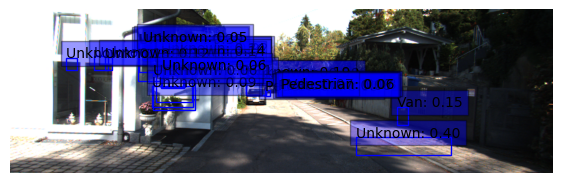

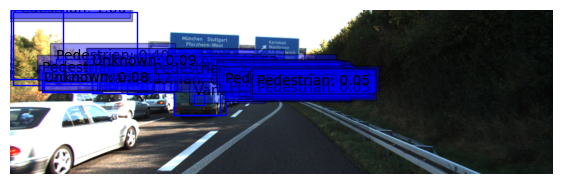

In [42]:
test_dataset = tfds.load("kitti", split="test", data_dir=DATA_PATH)
dataset_info = tfds.builder("kitti").info
int2str = dataset_info.features["objects"]["type"].int2str

def prepare_image(image):
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])
    input_image = transform(image).unsqueeze(0)
    return input_image, 1

for sample in test_dataset.take(2):
    image = sample["image"].numpy()
    input_image, ratio = prepare_image(image)
    with torch.no_grad():
        detections = inference_model(input_image)
        if isinstance(detections, list):
            detections = detections[0]
    num_detections = len(detections["scores"])

    class_names = [
        int2str(int(x)) if 0 <= int(x) < dataset_info.features["objects"]["type"].num_classes else "Unknown"
        for x in detections["labels"][:num_detections]
    ]

    visualize_detections(
        image,
        detections["boxes"][:num_detections] / ratio,
        class_names,
        detections["scores"][:num_detections],
    )

In [43]:
img_path = os.getenv('HOME')+'/work/object_detection/data/stop_1.png'

def self_drive_assist(img_path, size_limit=300):
    # 코드 구현
        # 정지조건에 맞으면 return "Stop"
        # 아닌 경우 return "Go"
    # 예외 상황을 포함하기위해서 어떤 기준이 또 필요할까요!?

print(self_drive_assist(img_path))

IndentationError: expected an indented block after function definition on line 3 (2283732918.py, line 9)

# 결론
학습 실행 실패...

## 과정 타임라인
1. 데이터셋 경로 문제 발생(file or directory no such, not found)
해당 문제는 /content 경로때문에 발생
content는 코랩 환경에서의 home 디텍토리이고 해당 코드를 현재 LMS작업중이기 때문에 home으로 변경하여 해결
2. 디렉토리 문제 발생(PermissionError)
해당 문제는 직접 지정한 work 폴더에 쓰기 권한이 없어 발생함
절대 경로 지정을 통해 해결
3. ModuleNotFoundError
pip를 통해 opencv 다운로드로 해결
4. 확장자 에러(ValueError)
최근 텐서플로우 버전부터 모델 저장 및 파일명 규칙이 엄격해져 발생함
확장자까지 작성하여 해결(.weights.h5)

LMS로 잘 하다가 실행도 안돼고 작동이 잘 안돼서 나융님이 보내주신 코랩 학습 파일로 다시 시도

코랩에서도 확장자 에러가 똑같이 발생해서 다시 .weights.h5 추가
그 후 차근차근 하던 중 학습 코드에서 rutin error 발생
원인은 num_worker 값은 2가 적당한데 4로 설정함
값이 너무 높은 경우 과부화나 연산량 문제 등의 이유로 런타임이 끊어지거나 오류가 발생할 수 있음
따라서 num_worker 값을 2로 조정 했지만 똑같은 에러가 발생함
서칭 해보니 아예 값을 0으로 지정하면 된다고 해서 0으로 지정 후 학습 코드를 다시 실행 했지만 또 rutin error 발생

생성형 모델을 사용하다 보니 코드가 점점 복잡해지고 점점 이해하기도 힘들어져서 다시 LMS에 있는 코드로 롤백 후 차근차근 다시 고쳐보기로 함

하지만 계속 rutin error와 value error가 다른 이유로 발생해서 시간 관계로 끝냄